## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

[GeoJson](https://tools.ietf.org/html/rfc7946#section-3.1.7) is a good way to add data on top of an ipyleaflet map.

For other backgrounds than open streets, you can alter the ipyleaflet.py file to point to one of [these map providers](https://leaflet-extras.github.io/leaflet-providers/preview/)

In [10]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [11]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pylab as plt

import sys
sys.path.append('./lib')

from leaflet import *

In [12]:
data_dir = "../../Data/Weather/"
from pickle import load
with open(data_dir+'/PRCP_residuals_PCA.pickle','rb') as file:
    Res_eig=load(file)
print Res_eig.keys()

#stations.pkl
with open(data_dir+'/stations.pkl','rb') as file:
    Stations=load(file)
Stations.head()


['eigen-vecs', 'stations']


latitude  longitude  elevation state                   name  \
ACW00011604   17.1167   -61.7833       10.1   NaN  ST JOHNS COOLIDGE FLD   
ACW00011647   17.1333   -61.7833       19.2   NaN               ST JOHNS   
AE000041196   25.3330    55.5170       34.0   NaN    SHARJAH INTER. AIRP   
AF000040930   35.3170    69.0170     3366.0   NaN           NORTH-SALANG   
AG000060390   36.7167     3.2500       24.0   NaN     ALGER-DAR EL BEIDA   

            GSNFLAG HCNFLAG    WMOID  
ACW00011604     NaN     NaN      NaN  
ACW00011647     NaN     NaN      NaN  
AE000041196     GSN     NaN  41196.0  
AF000040930     GSN     NaN  40930.0  
AG000060390     GSN     NaN  60390.0

In [13]:
import pandas as pd
Eig=pd.DataFrame(Res_eig['eigen-vecs'].transpose())
Eig.head()

0         1         2         3
0 -0.119973 -0.119229  0.002337  0.069874
1 -0.147773  0.084399  0.060399 -0.029892
2 -0.174988 -0.004611  0.009333 -0.050979
3 -0.148295  0.092466  0.036414 -0.038096
4 -0.169614  0.080814  0.043074 -0.031368

In [14]:
Eig['station']=Res_eig['stations']
Eig=Eig.set_index('station')
print Res_eig['stations'][:5]
Eig.head()

[u'USC00299657', u'USC00292810', u'US1NMSM0005', u'US1NMBR0053', u'US1NMSM0007']


0         1         2         3
station                                            
USC00299657 -0.119973 -0.119229  0.002337  0.069874
USC00292810 -0.147773  0.084399  0.060399 -0.029892
US1NMSM0005 -0.174988 -0.004611  0.009333 -0.050979
US1NMBR0053 -0.148295  0.092466  0.036414 -0.038096
US1NMSM0007 -0.169614  0.080814  0.043074 -0.031368

In [15]:
table=Eig.join(Stations,how='left')

In [16]:
#table=table[['name','latitude','longitude','elevation',0,1,2,3,4,5,6,7]]
table=table[['name','latitude','longitude','elevation',0,1,2,3]]
table.head(4)

name  latitude  longitude  elevation         0  \
station                                                                      
USC00299657        WESTBROOK RCH   35.9333  -108.2000     2012.9 -0.119973   
USC00292810    EL PUEBLO PROJECT   35.2833  -105.2667     1708.1 -0.147773   
US1NMSM0005     LAS VEGAS 8.4 NW   35.6680  -105.3423     2292.1 -0.174988   
US1NMBR0053  ALBUQUERQUE 3.1 ENE   35.1377  -106.5767     1610.9 -0.148295   

                    1         2         3  
station                                    
USC00299657 -0.119229  0.002337  0.069874  
USC00292810  0.084399  0.060399 -0.029892  
US1NMSM0005 -0.004611  0.009333 -0.050979  
US1NMBR0053  0.092466  0.036414 -0.038096

In [17]:
import pylab as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [25]:
print colors
#blue, orange, green, red

[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']


In [22]:
i,r = next(table.iterrows())
print r[0]
print r[1]
print r[2]
print r[3]

-0.119972942267
-0.119228701519
0.00233702379829
0.0698741972607


## Map

In [34]:
min_lat,max_lat,min_long,max_long = box = (35.0833, 36.0456, -108.4447, -105.1419)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8
m = Map(default_tiles=TileLayer(opacity=0.4), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m +=poly
m    

Widget Javascript not detected.  It may not be installed or enabled properly.


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

KeyError: 'avg(1)'

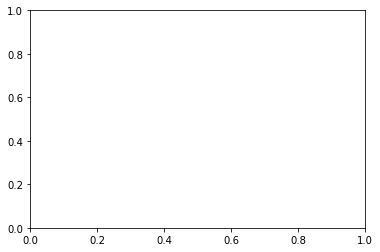

In [29]:
%matplotlib inline
Stations.plot.scatter(x='elevation',y='avg(1)');